## Initialization

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [94]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,GlobalAveragePooling2D, AveragePooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
import matplotlib.pyplot as plt
import seaborn as sns

In [95]:
# Loading phtos with data generator

def load_train(path):
   
    labels = pd.read_csv(path+'labels.csv')                                                    
    train_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25) 
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        horizontal_flip=True,
        seed=42)
    return train_datagen_flow, labels

In [96]:
train_datagen_flow, labels = load_train('/datasets/faces/')

Found 5694 validated image filenames.


In [97]:
features, target = next(train_datagen_flow)

## EDA

In [98]:
print("Dataset size\n------------")
print(f"rows:    {labels.shape[0]}")
print(f"columns: {labels.shape[1]}")

Dataset size
------------
rows:    7591
columns: 2


<AxesSubplot:xlabel='real_age', ylabel='Count'>

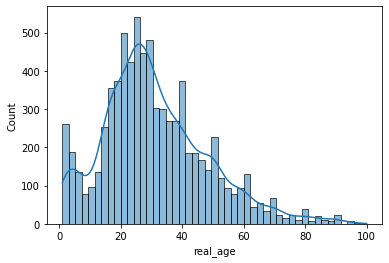

In [99]:
# Ploting age histogram
sns.histplot(data=labels, x='real_age', kde=True)

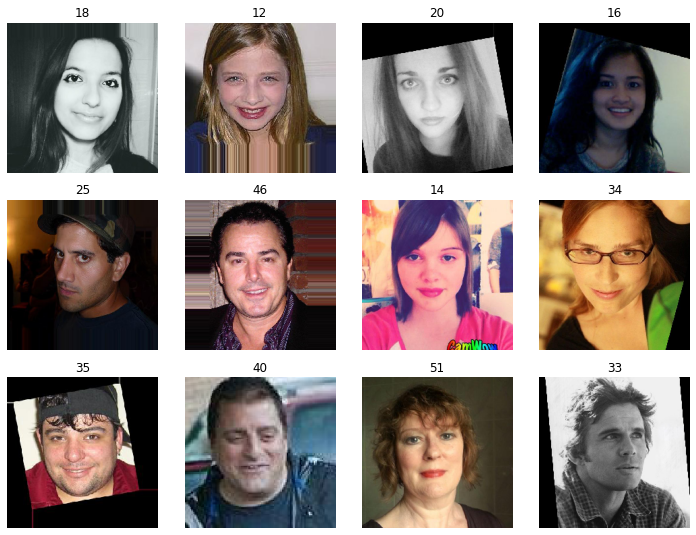

In [100]:
# Printing 12 photos  
plt.figure(figsize=(10, 10))
for image, target, i in zip(features[:12], target[:12], range(12)):
    plt.subplot(4, 4, i + 1)
    plt.imshow(image)
    plt.title(target)
    plt.axis("off")
plt.tight_layout()

### Findings

* Most of the photos are of people between 20 and 40
* It sohuldn't affect a neural network model
* From a quick glance at sample of the pictures the real age seems right.

## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [101]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [102]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    
    labels = pd.read_csv(path+'labels.csv')                                                     
    train_datagen = ImageDataGenerator(rescale= 1/255, validation_split=0.25)  
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        horizontal_flip=True,
        seed=42)

    return train_gen_flow

In [103]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    
    labels = pd.read_csv(path+'labels.csv')  
    test_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25)  
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation', 
        seed=42)

    return test_gen_flow

In [107]:
def create_model(input_shape):
    
    """
    It defines the model
    """
    
    backbone = ResNet50(input_shape= input_shape,
                    weights='imagenet', 
                    include_top= False)
 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mean_squared_error',metrics=['mae']) 
    return model

    return model

In [110]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data, 
              validation_data= test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    
    return model

### Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [111]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Place the output from the GPU platform as an Markdown cell here.

Train for 178 steps, validate for 60 steps
Epoch 1/10
2022-09-22 09:40:41.052115: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-09-22 09:40:42.056141: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 56s - loss: 182.8757 - mae: 10.1718 - val_loss: 715.3300 - val_mae: 21.7014
Epoch 2/10
178/178 - 37s - loss: 98.9539 - mae: 7.5867 - val_loss: 299.2555 - val_mae: 12.8458
Epoch 3/10
178/178 - 37s - loss: 69.5680 - mae: 6.2864 - val_loss: 320.8836 - val_mae: 13.2317
Epoch 4/10
178/178 - 37s - loss: 49.1477 - mae: 5.3865 - val_loss: 206.4292 - val_mae: 10.6947
Epoch 5/10
178/178 - 37s - loss: 31.4572 - mae: 4.2895 - val_loss: 103.1431 - val_mae: 7.7422
Epoch 6/10
178/178 - 37s - loss: 22.8143 - mae: 3.6733 - val_loss: 154.5533 - val_mae: 10.1125
Epoch 7/10
178/178 - 37s - loss: 17.6071 - mae: 3.2288 - val_loss: 80.2740 - val_mae: 6.7860
Epoch 8/10
178/178 - 37s - loss: 14.0544 - mae: 2.8568 - val_loss: 85.3217 - val_mae: 7.1596
Epoch 9/10
178/178 - 37s - loss: 12.8183 - mae: 2.7503 - val_loss: 82.2497 - val_mae: 6.9593
Epoch 10/10
178/178 - 37s - loss: 10.9885 - mae: 2.5371 - val_loss: 85.2515 - val_mae: 7.0806
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 85.2515 - mae: 7.0806
Test MAE: 7.0806

## Conclusions

* The model is succeful in predicting age from pictures with a Mean avarage error of around 7 years
* It was right to use the weights of the pretraind imagenet model